In [2]:
!pip install transformers==4.17.0 datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; pla

In [9]:
# === Imports ===
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import torch

# === Load and preprocess dataset ===
df = pd.read_csv('/content/labeled_data.csv')

# Drop irrelevant columns
df.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], inplace=True)

# Clean text: keep only letters
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex=True)
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex=True)
df.drop(columns=['tweet', 'processed_tweet'], inplace=True)

# Load SpaCy and apply lemmatization
nlp = spacy.load('en_core_web_sm')

def lemmatization(text):
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])

df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)

# Remove stopwords
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([word.text for word in doc if not word.is_stop])

df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

# Prepare features and labels
X_text = df['final_tweet'].tolist()
y = df['class'].values

# Create a new DataFrame for Hugging Face
hf_df = pd.DataFrame({'text': X_text, 'label': y})

# Tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize function
def tokenize(example):
    return tokenizer(example['text'], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(hf_df)
tokenized_dataset = dataset.map(tokenize, batched=True)

# Extract features and labels for SMOTE and Train-Test Split
X_tokens = tokenized_dataset["input_ids"]
X_np = np.array(X_tokens)
y_np = np.array(tokenized_dataset["label"])

# Resample with SMOTE (optional with transformer, use carefully)
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_np, y_np)

# Rebuild Hugging Face Dataset
df_resampled = pd.DataFrame({'input_ids': X_resampled.tolist(), 'label': y_resampled})
dataset_resampled = Dataset.from_pandas(df_resampled)

# Add attention masks
def add_attention(example):
    example['attention_mask'] = [int(token_id > 0) for token_id in example['input_ids']]
    return example

dataset_resampled = dataset_resampled.map(add_attention)

# Final split
dataset_split = dataset_resampled.train_test_split(test_size=0.2)

# Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

# Training arguments optimized for A100
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    dataloader_num_workers=4,
    report_to="none",
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()


loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/dfe8f1ad04cb25b61a647e3d13620f9bf0a0f51d277897b232a5735297134132.024cc07195c0ba0b51d4f80061c6115996ff26233f3d04788855b23cdf13fbd5
loading configuratio

Map:   0%|          | 0/24783 [00:00<?, ? examples/s]

Map:   0%|          | 0/42543 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.312200,0.277168,0.916794,0.865083,0.911908,0.882347
2,0.228400,0.296011,0.921612,0.909323,0.862071,0.880620
3,0.215700,0.242535,0.937243,0.914541,0.918974,0.915594
4,0.197300,0.214313,0.938418,0.912776,0.924885,0.917758
5,0.178100,0.199387,0.939593,0.920393,0.923885,0.921077


***** Running Evaluation *****
  Num examples = 8509
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-1064
Configuration saved in ./results/checkpoint-1064/config.json
Model weights saved in ./results/checkpoint-1064/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1064/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1064/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-2480] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 8509
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-2128
Configuration saved in ./results/checkpoint-2128/config.json
Model weights saved in ./results/checkpoint-2128/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2128/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2128/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-6200] due to args.save_total_limit
***** Running Ev

TrainOutput(global_step=5320, training_loss=0.24598743037173623, metrics={'train_runtime': 771.6326, 'train_samples_per_second': 220.532, 'train_steps_per_second': 6.894, 'total_flos': 1.119350257369344e+16, 'train_loss': 0.24598743037173623, 'epoch': 5.0})

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer if not already in memory
# model = AutoModelForSequenceClassification.from_pretrained("./results/checkpoint-best")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Map of model class indices to human-readable labels
label_map = {
    0: "Hate Speech",
    1: "Offensive",
    2: "Neither"
}

# Function to predict on custom text
def predict(text):
    # Ensure consistency of device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize and move to device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return label_map[predicted_class], probs[0].cpu().numpy()

# Example usage
examples = [
    "People like you shouldn't even be allowed here.",
    "You're such an idiot.",
    "People like you don't deserve to live.",
    "Shut up already, nobody cares."
]

for sentence in examples:
    label, prob = predict(sentence)
    print(f"\nText: {sentence}\nPredicted: {label}\nConfidence: {prob}")



Text: People like you shouldn't even be allowed here.
Predicted: Offensive
Confidence: [0.20942272 0.7600445  0.03053284]

Text: You're such an idiot.
Predicted: Offensive
Confidence: [0.33356878 0.5940848  0.0723464 ]

Text: People like you don't deserve to live.
Predicted: Offensive
Confidence: [0.27846843 0.67289823 0.04863328]

Text: Shut up already, nobody cares.
Predicted: Offensive
Confidence: [0.23357338 0.729951   0.03647561]


In [11]:
# Run evaluation using the Trainer's built-in method
eval_result = trainer.evaluate()

# Print loss and accuracy
print(f"Model Loss     : {eval_result['eval_loss']:.4f}")
print(f"Model Accuracy : {eval_result['eval_accuracy'] * 100:.2f}%")


***** Running Evaluation *****
  Num examples = 8509
  Batch size = 128


Model Loss     : 0.1994
Model Accuracy : 93.96%


In [12]:
# Evaluate on the test set
eval_results = trainer.evaluate()

# Print basic metrics
print("\n📊 Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


***** Running Evaluation *****
  Num examples = 8509
  Batch size = 128



📊 Evaluation Results:
eval_loss: 0.1994
eval_accuracy: 0.9396
eval_precision_macro: 0.9204
eval_recall_macro: 0.9239
eval_f1_macro: 0.9211
eval_runtime: 10.5467
eval_samples_per_second: 806.7890
eval_steps_per_second: 6.3530
epoch: 5.0000


***** Running Prediction *****
  Num examples = 8509
  Batch size = 128


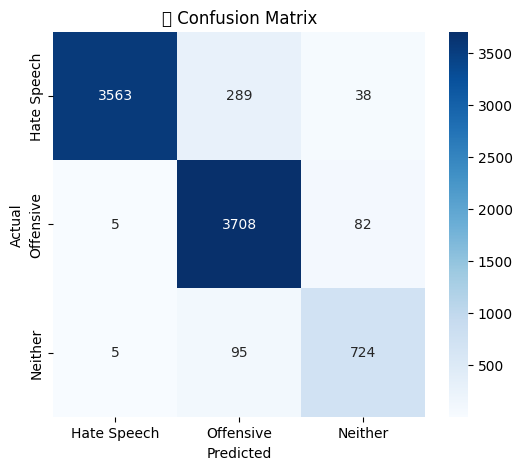

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions and true labels from test set
predictions = trainer.predict(dataset_split["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

labels = ["Hate Speech", "Offensive", "Neither"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📌 Confusion Matrix")
plt.show()
